In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR

import wandb
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from funciones import Args, save_best_model
from Etapa1.modelsMultitalk.stage1_vocaset import VQAutoEncoder
from transformers import GPT2Config, GPT2LMHeadModel
import wandb
from tree_functions import *
from tree_viewer import *
from tqdm.auto import trange, tqdm
from torch.nn.utils.rnn import pad_sequence
from funciones import *

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(12)
torch.cuda.manual_seed(12)
np.random.seed(12)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
args = Args()

args.in_dim = 39
args.hidden_size = 1024
args.feature_dim = 64
args.face_quan_num = 16
args.base_lr = 5e-3
args.step_size = 150
args.gamma = 0.9

**Utils**

In [3]:
def red(text): return f"\033[31m{str(text)}\033[0m"
def green(text): return f"\033[32m{str(text)}\033[0m"
def yellow(text): return f"\033[33m{str(text)}\033[0m"
def blue(text): return f"\033[34m{str(text)}\033[0m"
def magenta(text): return f"\033[35m{str(text)}\033[0m"
def cyan(text): return f"\033[36m{str(text)}\033[0m"
def bold(text): return f"\033[1m{str(text)}\033[0m"
    
def exists_in_dataset(tokens, dataset):
    
    tokens = tokens.cpu()

    for idx, item in enumerate(dataset):
        item = item.cpu()
        if len(item) == len(tokens) and (tokens == item).all().item() : return True, idx

    return False, -1

def common_prefix(tokens, tokens_b):

    idx = 0
    while idx < min(len(tokens), len(tokens_b)) and tokens[idx] == tokens_b[idx]:
        idx += 1

    return idx - 1

def longest_common_prefix(tokens, dataset):

    max_index = 0
    dataset_index = -1

    for idx, item in enumerate(dataset):
        
        index = common_prefix(tokens, item)

        if index > max_index: 
            max_index = index
            dataset_index = idx

    return max_index, dataset_index

**GPT2 and VQAutoencoder loading**

In [4]:
gpt2_name = "models/gpt2/gpt2-new"
autoencoder_name = "aneux/models/stage1/aneux/best-model-aneux15batchzr.pth"
p=15
#dataset_name = "dataset_21_2_2/tokenized/train"

model = GPT2LMHeadModel.from_pretrained("models/gpt2/" + gpt2_name)   # cuando cambias el gpt acordarse de modificar max_size y el dataset de eval
model.to(device)

# -----------------------

autoencoder = VQAutoEncoder(args).to(device)

checkpoint = torch.load("models/stage1/" + autoencoder_name, map_location = device)
autoencoder.load_state_dict(checkpoint['model_state_dict'])

model.eval()
autoencoder.eval()
print(checkpoint['epoch'])
0

OSError: Incorrect path_or_model_id: 'models/gpt2/models/gpt2/gpt2-new'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [29]:
validation = sorted(os.listdir("Datos/AneuxSplines/zero-root/tokenized/p15/val")) #ACA VA LO TOKENIZADO
val_data = []
for file in validation:
    val_data.append(torch.load("Datos/AneuxSplines/zero-root/tokenized/p15/val" + "/" + file, weights_only = False))

In [30]:
print(f"Validation set size: {len(val_data)}")

Validation set size: 52


In [31]:
val_data[0].shape

torch.Size([1552])

In [41]:
def clean(tree):
    tn = []
    for coeffs in tree:
        coeffs = list(coeffs)
        t = np.array(coeffs[24:])
        print("t antes:", t)
        t = np.where(np.abs(t - 1) < 0.01, 1.0, t)
        print("t despues:", t)
        coeffs[24:] = t.tolist()
        tn.append(coeffs)
    return np.array(t)

**GPT2 tokens generation**

In [42]:
max_size = 2512 + 2
pad_token = 257
eos_token = 256

def gpt2_generate(n_samples, start_seq, tmp, save = False, dest = None, autoencoder = None, num_beams = 1):
    

    samples = []

    for i in tqdm(range(n_samples)):
        start_seq = torch.tensor([[eos_token]]).to(device)
        val_prefix = val_data[i][:16].unsqueeze(0).to(device)  # Shape: (1, 16)

        # Concatenate along the sequence dimension
        start_seq = torch.cat((start_seq, val_prefix), dim=1)
        tokens = model.generate(start_seq, max_length = max_size, temperature = tmp, do_sample = True, eos_token_id = eos_token, pad_token_id = pad_token, num_beams = num_beams).flatten()
        samples.append(tokens)

   
    if save:
        dest = os.path.join("generated/aneux", dest)
        if not os.path.exists(dest):
            os.makedirs(dest)
        erase_all_files(dest)

        #for idx, sample in enumerate(samples): 
        #    torch.save(sample, dest + "/tokenized" + str(idx) + ".tok")
        for idx, sample in enumerate(samples): 
            try:
                data = tokens_to_data(sample, device, autoencoder).numpy()                                  # AGREGAR THRESHOLD <.............
                data[abs(data) < 1e-2] = 0 
                data = clean(data)  # Clean the data
                np.save(dest+"/"+str(idx)+".npy", data)
            except Exception as e:
                print(red("Error processing sample {}: {}".format(idx, e)))
                print("Error idx:", idx)
                

    return samples

    return samples

# ---------------------------------------------------------------------------------------------------------------------------------------

start_seq = torch.tensor([[eos_token]]).to(device)
tmp = 1.
num_beams = 1
autoencoder_name = os.path.splitext(os.path.basename(autoencoder_name))[0]
folder_name = f"p{p}_beam{num_beams}_a{autoencoder_name}_gpt2{gpt2_name}"


samples = gpt2_generate(n_samples = 5, start_seq = start_seq, tmp = tmp, save = True, dest = folder_name, autoencoder= autoencoder, num_beams= num_beams)  
#nombre de la carpeta a guardar: p + profundidad + beam + tamaño del beam + nombre autoencoder + nombre gpt2

  0%|          | 0/5 [00:00<?, ?it/s]

t antes: [[-0.0493699   0.05555555  0.07132725 ...  0.14347976  0.15956526
   0.1926247 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.20994455  0.2267789   0.17188969 ...  1.1348513   1.296457
   1.5343531 ]
 ...
 [ 0.11166734  0.12643881 -0.07482637 ...  1.1396533   1.272874
   1.474326  ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.01493232 ...  0.          0.
   0.        ]]
t despues: [[-0.0493699   0.05555555  0.07132725 ...  0.14347976  0.15956526
   0.1926247 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.20994455  0.2267789   0.17188969 ...  1.1348513   1.296457
   1.5343531 ]
 ...
 [ 0.11166734  0.12643881 -0.07482637 ...  1.1396533   1.272874
   1.474326  ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.01493232 ...  0.          0.
   0.        ]]
t antes: [[ 0.10518527  0.57872707 -0.10487072 ...  

In [38]:
a = 0
arboles_np = []
for i, sample in enumerate(samples):
    try:
        data = tokens_to_data(sample, device, autoencoder).numpy()                                  # AGREGAR THRESHOLD <.............
        #data = np.load("datasets/stage1/train/numpy_preorder/a-0002-eps01.npy")

        data[abs(data) < 1e-2] = 0 
        print(data[0].shape)
        #np.save("generated/p20-beam4/"+str(i)+".npy", data[0])
        serial = list(data.flatten())
        arboles_np.append(data[0])
        tree, _ = deserialize_pre_order_k(serial, k = 39)
        #draw_tree_splines(tree)
        if data[0].shape[0] < 10:  a += 1
    except:
        print("Error")
        a += 1
        continue
print(a)

(47, 39)
(81, 39)
(55, 39)
(75, 39)
(97, 39)
(87, 39)
Error
(69, 39)
(77, 39)
(65, 39)
1


In [39]:
arboles_np[0].shape

(47, 39)

generado [0.8955665, 0.8753739, -1.5028714, -0.67167133, 0.89982253, -0.016340185, -0.8993261, 0.98174983, -0.7383771, 0.8578028, -0.1631946, -0.31089893, 1.1307974, 1.0362573, -0.525655, -0.1669425, -0.14385541, 1.1367754, 0.88843346, 0.56770533, 0.35740644, 0.28827015, 0.6634816, 0.1662408, 0.6758602, 0.37961322, 0.17479314, 3.605483, 0.9502579, 1.8370275, -0.20075183, -4.1571174, -4.993514, -7.081685, -6.692756, -8.264984, -11.653231, -11.378808, -12.91143, -0.17522164, -0.20042306, 0.13263012, -0.06623525, -0.11355, -0.13628757, -0.09808199, -0.049444757, -0.06265582, -0.11353992, -0.13483891, -0.20694757, -0.2117675, -0.23318967, -0.20775543, -0.1792081, -0.20921059, -0.21232009, -0.23006915, 0.15610488, 0.17534998, 0.10226224, 0.030449625, 0.070245944, 0.15654878, 0.17142726, 0.09862775, -0.92611474, -0.59420604, -0.2678492, 0.0, 0.27653918, 0.58057356, 0.9101026, 1.230277, 1.5104889, 1.4736248, 1.4598812, 1.4693114, 0.04383824, -0.033627715, 0.07496318, 0.023548687, -0.030604312

TypeError: tuple indices must be integers or slices, not tuple

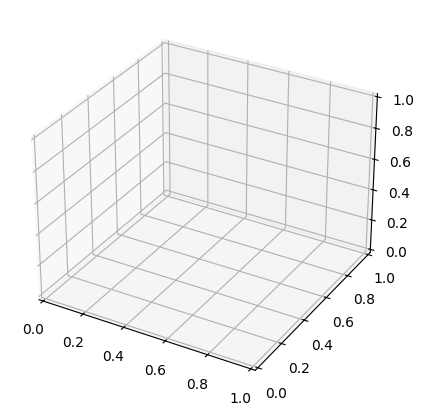

In [40]:
from tree_viewer import draw_tree_splines
from tree_functions import deserialize_pre_order_k

serial = list(arboles_np[0].flatten())
print("generado", serial)
tree, _ = deserialize_pre_order_k(serial, k = 39)
draw_tree_splines(tree)

In [ ]:
class TokenDataset(Dataset):

    def __init__(self, folder_path):

        self.samples = []
        self._load_files(folder_path)

    def _load_files(self, folder_path):

        for file_name in os.listdir(folder_path):

            file_path = os.path.join(folder_path, file_name)
            self.samples.append(torch.load(file_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):

        eos = torch.tensor([eos_token])
        seq = torch.cat((eos, self.samples[idx], eos))

        return torch.tensor(seq, dtype = torch.long)

dataset = TokenDataset("./datasets/" + dataset_name)
len(dataset)

NameError: name 'dataset_name' is not defined

In [ ]:
#data = np.load("datasets/dataset_aneurisk/numpy_preorder/p15Eps01-p15Eps01099_tree.dat.npy")
#draw_tree_from_numpy(data)

< tokens_to_tree error >

dataset_21_2_2/tokenized/train 
 AE : aneurisk-limpio-splines.pth 
 gpt2 : gpt2-new 
 tmp. 1.0


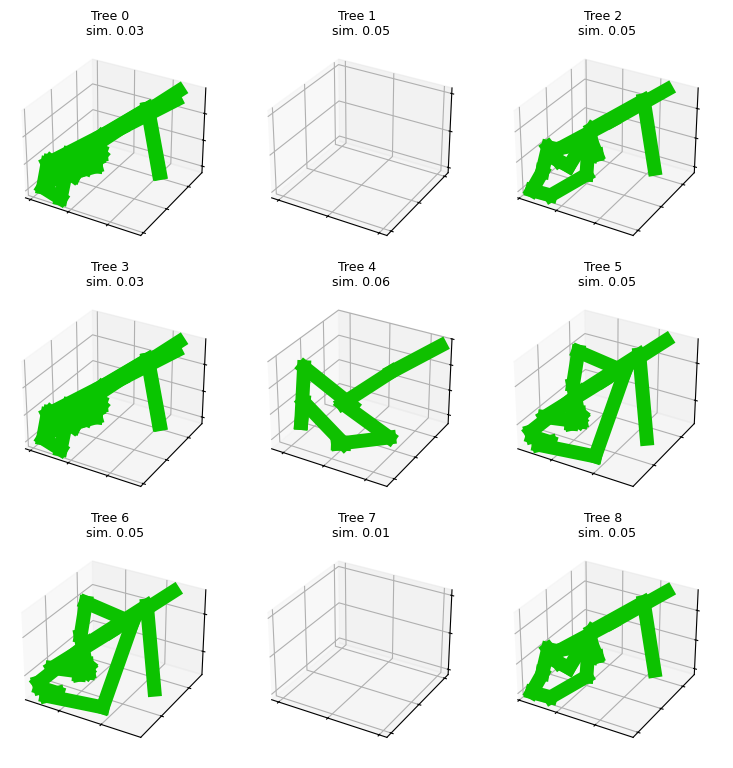

In [ ]:
def interpolate(p1, p2, alpha):
    return tuple((1 - alpha) * a + alpha * b for a, b in zip(p1, p2))

def similarity(a, b):

    a = a.cpu()

    min_l = min(len(a), len(b))
    return torch.sum(b[:min_l] == a[:min_l]).item() / len(a)

def max_similarity(a, dataset):

    max_s = 0

    for item in dataset:
        max_s = max(max_s, similarity(a, item))

    return np.round(max_s, 4)

def samples_max_similarity(samples, dataset):

    max_similarities = []

    for sample in tqdm(samples):
        max_similarities.append(max_similarity(sample, dataset))

    plt.title("samples max similarity with respect to dataset\n")

    plt.hist(max_similarities)

    plt.xlabel("similarity")
    plt.ylabel("frequency")

    plt.xlim(0,1)

    return max_similarities

def draw_tree_grid_from_samples(samples, mode = "pre_order", threshold = 1e-2, device = None, decoder = None):

    trees = []
    params_list = []

    for tokens in samples:

        tree = tokens_to_tree(tokens, device = device, decoder = decoder)    
        if tree == None: tree = Tree({"x":0, "y":0, "z":0, "r":0})

        trees.append(tree)

        # -------------------------------------------------------------

        sim = max_similarity(tokens, dataset)
        params_list.append({"text": "sim. " + str(np.round(sim,2)), "line_color" : interpolate((0,0.8,0), (1,0,0), sim), "node_size": 0, "radius_alpha": 50})

    print(f"\n{dataset_name} \n AE : {autoencoder_name} \n gpt2 : {gpt2_name} \n tmp. {tmp}")
    draw_tree_grid(trees, set_lims = False, figsize = 3, params = params_list)

draw_tree_grid_from_samples(samples, device = device, decoder = autoencoder)

**Generation Evaluation**

In [ ]:
def eval(samples, dataset, verbose = True):

    if verbose:
        print(bold(yellow("NOVEL TREES")))
        print(red("(index)"), ":", red("index"), "of tree in dataset \n")

    novels = []

    for i, sample in enumerate(samples):

        sample_str = list(sample.cpu().numpy())

        exist, idx = exists_in_dataset(sample, dataset)

        if not exist:
            if verbose: print(green(i) + green(" ✔\t\t"), green(sample_str))
            novels.append((i, sample))
        else:
            if verbose: print(i, red("✖ (" + str(idx) + ")\t"), sample_str)

    novelty = np.round(1 - (len(samples) - len(novels)) / len(samples), 4) * 100

    if verbose: 
        
        print(bold("\nNovelty :"), yellow(bold(np.round(novelty, 2))), yellow("%"))
        print("-------------------------------------------------------------------------------------------------------------------------------\n")

        print(bold(yellow("LONGEST COMMON PREFIX")))
        print(green("(index)"), ":", green("index"), "of subtree in dataset \n")

    valids = []
    error = None

    for i, sample in novels:

        sample_aux = list(sample.cpu().numpy())
        max_index, dataset_index = longest_common_prefix(sample_aux, dataset)

        if verbose: print(i, green("\t(" + str(dataset_index) + ")\t"), green(sample_aux[:max_index + 1]))
        
        valids.append(is_valid_tree(sample, device = device, decoder = autoencoder))

    error = np.round(1 - np.mean(valids), 4) * 100

    if verbose: 

        print("-------------------------------------------------------------------------------------------------------------------------------\n")
        print(bold("Error :"), red(bold(error)), red("%"))

    return novels, novelty, error

novels, novelty, error = eval(samples, dataset)

NOVEL TREES
(index) : index of tree in dataset 

0 ✔		 [np.int64(256), np.int64(220), np.int64(104), np.int64(238), np.int64(159), np.int64(238), np.int64(226), np.int64(146), np.int64(232), np.int64(198), np.int64(138), np.int64(122), np.int64(213), np.int64(195), np.int64(186), np.int64(186), np.int64(189), np.int64(240), np.int64(22), np.int64(26), np.int64(112), np.int64(247), np.int64(46), np.int64(166), np.int64(131), np.int64(39), np.int64(11), np.int64(17), np.int64(246), np.int64(42), np.int64(195), np.int64(24), np.int64(68), np.int64(176), np.int64(131), np.int64(104), np.int64(67), np.int64(192), np.int64(172), np.int64(224), np.int64(87), np.int64(198), np.int64(164), np.int64(131), np.int64(97), np.int64(123), np.int64(239), np.int64(68), np.int64(87), np.int64(184), np.int64(101), np.int64(131), np.int64(68), np.int64(131), np.int64(120), np.int64(255), np.int64(195), np.int64(39), np.int64(66), np.int64(79), np.int64(217), np.int64(79), np.int64(85), np.int64(6), np.int

**Temperature vs. Novelty vs. Error**

In [ ]:
def tmp_experiment():

    data = {"tmp" : [], "novelty" : [], "error" : []}

    #print(bold(yellow("tmp")), green("novelty"), red("error"))

    for tmp in tqdm(np.linspace(0.01, 5., 50)):

        data["tmp"].append(tmp)

        samples = gpt2_generate(n_samples = 20, start_seq = start_seq, tmp = tmp, save = False, dest = "")
        _, novelty, error = eval(samples, dataset, verbose = False)
        
        data["novelty"].append(novelty)
        data["error"].append(error)

        #print(bold(yellow(np.round(tmp, 2))), green(np.round(novelty,2)), red(np.round(error, 2)))

    plt.xlabel("temperature")
    plt.ylabel("novelty | error")

    plt.plot(data["tmp"], data["novelty"], c = "g", label = "novelty")
    plt.plot(data["tmp"], data["error"], c = "r", label = "error")

    plt.legend()

#tmp_experiment()

100%|██████████| 10/10 [00:00<00:00, 77.24it/s]

561 [np.float64(0.0274), np.float64(0.0488), np.float64(0.0488), np.float64(0.0274), np.float64(0.06), np.float64(0.0366), np.float64(0.0366), np.float64(0.0091), np.float64(0.0488), np.float64(0.0488)]


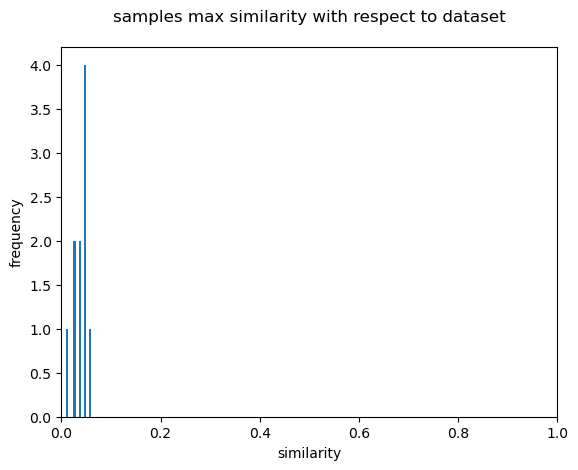

In [ ]:
dataset_to_compare = TokenDataset("datasets/dataset_21_2/tokenized/train")

max_similarities = samples_max_similarity(samples, dataset_to_compare)
print(len(dataset_to_compare), max_similarities)